## Libraries

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

In [3]:
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
sns.set(style='darkgrid')

In [4]:
from tqdm import tqdm

In [5]:
import tensorflow as tf

## Read data & preprocessing

In [6]:
# read training data
df_X = pd.read_csv('./data/X_train.csv')
df_y = pd.read_csv('./data/y_train.csv')

In [7]:
# convert into np array, check shape
X_raw = np.array(df_X)[:, 1:]
print(X_raw.shape)

y_raw = np.array(df_y, dtype=int)[:, 1]
print(y_raw.shape)

num_samples = X_raw.shape[0]
num_features = X_raw.shape[1]

(5117, 17813)
(5117,)


In [8]:
# data frames no longer needed
del df_X, df_y

In [9]:
# shuffle the dataset
X_raw, y_raw = shuffle(X_raw, y_raw)

In [10]:
# recordings trimmed of NaNs
recordings = []
for i in range(X_raw.shape[0]):
    recordings.append(X_raw[i, ~np.isnan(X_raw[i,:])])

print(recordings[0])

[-450. -436. -426. ... 3094. 2890. 2681.]


In [ ]:
# dataset augmented by repetition
def augmentation(X):
    augmented = np.copy(X)
    for i in range(X.shape[0]):
        n = 17813
        for j in range(X.shape[1]):
            if np.isnan(X[i,j]):
                n = j
                break
        for j in range(n, X.shape[1]):
            augmented[i,j] = X[i, j%n]
        
    return augmented

X_augmented = augmentation(X_raw)

# make sure no more NaN exists
np.sum(np.isnan(X_augmented))

In [ ]:
X_train = X_augmented[0:5000, :]
X_validation = X_augmented[5000:, :]
y_train = y_raw[0:5000]
y_validation = y_raw[5000:]

In [ ]:
# check group balance
print(np.sum(y_train == 0), np.sum(y_train == 1), np.sum(y_train == 2), np.sum(y_train == 3))
print(np.sum(y_validation == 0), np.sum(y_validation == 1), np.sum(y_validation == 2), np.sum(y_validation == 3))

In [ ]:
# dynamic time warpping -- too slow to be used
def constrained_dtw(t1, t2, w=float('inf'), matrix=False):
    n1 = len(t1)
    n2 = len(t2)
    if w < abs(n1 - n2):
        print('ERROR: constraint smaller than difference in length.')
        exit(1)
    
    # distance matrix with infinity for all entries
    dist_matrix = np.ones((n1+1, n2+1)) * float('inf')
    dist_matrix[0,0] = 0
    
    # distance within the contrained range
    for i in range(n1):
        for j in range(n2): 
            if abs(i-j) <= w:
                dist_matrix[i+1,j+1] = abs(t1[i] - t2[j]) + min(dist_matrix[i,j], dist_matrix[i+1,j], dist_matrix[i,j+1])
    
    if matrix: 
        return dist_matrix
    else:
        return dist_matrix[n1,n2]

In [ ]:
a = np.array([np.sin(x*0.5) for x in range(100)])
#plt.plot(a)
plt.plot(np.fft.rfft(a))

In [ ]:
plt.figure(figsize=(16,8))
plt.ylim(-2048, 2048)

n1 = 2
plt.plot(recordings[n1])
plt.show()
print('class:', y_raw[n1])
print('mean:', np.mean(recordings[n1]))
print('variance:', np.var(recordings[n1]))

## Feature Extraction

In [11]:
from biosppy.signals import ecg

In [12]:
# extract R peaks
peaks = []
for i in tqdm(range(len(recordings))): 
    out = ecg.hamilton_segmenter(signal=recordings[i], sampling_rate=300)
    peaks.append(out[0])

100%|██████████| 5117/5117 [01:17<00:00, 66.23it/s]


In [13]:
# find least and greatest number of peaks
least = len(peaks[0])
least_id = 0
most = len(peaks[0])
most_id = 0

for i in range(1,len(peaks)):
    if len(peaks[i]) < least:
        least = len(peaks[i])
        least_id = i
    if len(peaks[i]) > most:
        most = len(peaks[i])
        most_id = i

print(least_id)
print(least)
print(most_id)
print(most)

2469
5
4769
158


In [14]:
len(recordings[0])

2917

In [15]:
recordings[0][327]

781.0

In [77]:
# augmentation
neighbourhood = 50
subsampling = 1
X_2d = np.zeros((len(peaks), most, 2*neighbourhood//subsampling))
for i in tqdm(range(len(peaks))):
    count = 0
    length = len(recordings[i])
    for r in peaks[i]:
        if r >= neighbourhood and r < length - neighbourhood:
            X_2d[i,count,:] = recordings[i][r-neighbourhood : r+neighbourhood : subsampling]
            count += 1
    
    for j in range(count, most):
        X_2d[i,j,:] = X_2d[i,j%count,:]
        

100%|██████████| 5117/5117 [00:00<00:00, 5721.56it/s]


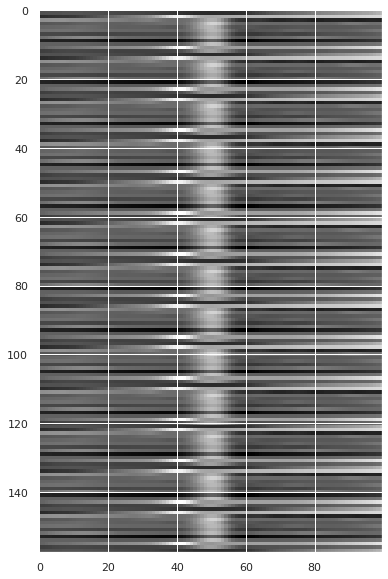

In [78]:
plt.figure(figsize=(10,10))
plt.imshow(X_2d[0], cmap='gray')

## CNN

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [37]:
def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    c2 = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    c3 = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    # if c3 == 0:
    #     return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score 

In [69]:
kernel_size = least
num_filters = 32
width = 2*neighbourhood // subsampling

model_1d = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(most, width)),
        
        tf.keras.layers.Conv1D(kernel_size=kernel_size, filters=num_filters, activation='relu'),
        
        tf.keras.layers.Conv1D(kernel_size=kernel_size, filters=num_filters, activation='relu'),
        
        tf.keras.layers.Conv1D(kernel_size=kernel_size, filters=num_filters, activation='relu'),
        
        tf.keras.layers.Conv1D(kernel_size=kernel_size, filters=num_filters, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ]
)

model_1d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])
model_1d.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 154, 32)           5152      
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 150, 32)           5152      
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 146, 32)           5152      
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 142, 32)           5152      
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 32)                0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)             

In [79]:
kernel_size = least
num_filters = 32
width = 2*neighbourhood // subsampling

model_2d = tf.keras.Sequential(
    [
        tf.keras.layers.Reshape(input_shape=(most, width), target_shape=(most, width, 1)),
        
        tf.keras.layers.Conv2D(kernel_size=least, filters=num_filters, activation='relu'),
        
        tf.keras.layers.Conv2D(kernel_size=least, filters=num_filters, activation='relu'),
        
        tf.keras.layers.Conv2D(kernel_size=least, filters=num_filters, activation='relu'),
        
        tf.keras.layers.GlobalMaxPooling2D(),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ]
)

model_2d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])
model_2d.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 158, 100, 1)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 154, 96, 32)       832       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 150, 92, 32)       25632     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 146, 88, 32)       25632     
_________________________________________________________________
global_max_pooling2d_7 (Glob (None, 32)                0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)             

In [80]:
X_2d.shape

(5117, 158, 100)

In [82]:
X_train = X_2d[:5000]
X_validation = X_2d[5000:]
y_train = y_raw[:5000]
y_validation = y_raw[5000:]

y_target = tf.keras.utils.to_categorical(y_train)
validation_dataset = (X_validation, tf.keras.utils.to_categorical(y_validation))

# check group balance
print(np.sum(y_train == 0), np.sum(y_train == 1), np.sum(y_train == 2), np.sum(y_train == 3))
print(np.sum(y_validation == 0), np.sum(y_validation == 1), np.sum(y_validation == 2), np.sum(y_validation == 3))

2948 431 1452 169
82 12 22 1


In [ ]:
model = model_2d
model.fit(x=X_train,
          y=y_target,
          batch_size=32, 
          epochs=32, 
          validation_data=validation_dataset)

Train on 5000 samples, validate on 117 samples
Epoch 1/32
5000/5000 [==============================] - 181s 36ms/sample - loss: 2.5248 - accuracy: 0.5258 - f1_score: nan - val_loss: 0.8885 - val_accuracy: 0.7009 - val_f1_score: 0.6774
Epoch 2/32
5000/5000 [==============================] - 181s 36ms/sample - loss: 1.0255 - accuracy: 0.5738 - f1_score: 0.4771 - val_loss: 0.8437 - val_accuracy: 0.7009 - val_f1_score: 0.6530
Epoch 3/32
5000/5000 [==============================] - 181s 36ms/sample - loss: 0.9929 - accuracy: 0.5848 - f1_score: 0.5191 - val_loss: 0.8699 - val_accuracy: 0.7009 - val_f1_score: 0.6607
Epoch 4/32
5000/5000 [==============================] - 181s 36ms/sample - loss: 0.9804 - accuracy: 0.5848 - f1_score: 0.5617 - val_loss: 0.8380 - val_accuracy: 0.7009 - val_f1_score: 0.6517
Epoch 5/32
5000/5000 [==============================] - 182s 36ms/sample - loss: 0.9907 - accuracy: 0.5852 - f1_score: 0.5516 - val_loss: 0.8739 - val_accuracy: 0.7009 - val_f1_score: 0.6979
E

## Predict

In [ ]:
df_test = pd.read_csv('./data/X_test.csv')
X_test = np.array(df_test)[:,1:]
X_test.shape

In [ ]:
del df_test

In [ ]:
X_test_augmented = augmentation(X_test)

In [ ]:
y_test = model.predict(X_test[:,0:15000:5])
y_test

In [ ]:
result = np.argmax(y_test, axis=1)
result

## Output

In [ ]:
# write output csv
out_df = pd.DataFrame(data={'y': result})
out_df.to_csv('result4.csv', index_label='id')